## Import Package

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import statistics

#from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV

# Classification
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm
import catboost as cat
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn import manifold, datasets
import optuna
import warnings
warnings.filterwarnings("ignore")

#remove outlier
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest


import shap

## Upload Datasets

In [20]:
data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore.csv")
data.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


# Descriptive Analysis

## Data Cleaning

In [21]:
def clean_data(data):
    data = data.drop(['App','Current Ver','Android Ver'], axis=1)
    data[~data.Reviews.str.isnumeric()]
    data=data.drop(data.index[10472])
    items_to_remove=['+',',','$'] # Remove special symbols
    cols_to_clean=['Installs','Price','Size']
    for item in items_to_remove:
        for col in cols_to_clean:
            data[col]=data[col].str.replace(item,'')
    data['Installs'] = data['Installs'].astype('int') # Change data type
    data['Price'] = data['Price'].astype('float')
    data['Reviews'] = data['Reviews'].astype('int')
    data['Size'] = data['Size'].str.replace('M','000')
    data['Size'] = data['Size'].str.replace('k','')
    data['Size'] = data['Size'].replace("Varies with device",np.nan)
    data['Size'] = data['Size'].astype('float')
    for i in data['Size']:
        if i < 10:
            data['Size'] = data['Size'].replace(i,i*1000)
    data['Size'] = data['Size']/1000

    null = pd.DataFrame({'Null Values':data.isna().sum().sort_values(ascending=False),
                    'Percentage Null Values':(data.isna().sum().sort_values(ascending=False))/(data.shape[0])*(100)})
    
    data=data.dropna() # Remove all null value
    data.drop_duplicates(inplace=True) #
    
    # Convert the 'last_updated' column to datetime, specifying the format
    data['Last Updated'] = pd.to_datetime(data['Last Updated'], format='%B %d, %Y')
    # Reference date (e.g., today's date)
    reference_date = pd.to_datetime("2018-08-08")
    # Calculate the number of days since the last update
    data['Days_since_last_update'] = (reference_date - data['Last Updated']).dt.days
    data = data.drop(['Last Updated'], axis=1)
    return data

In [22]:
data=clean_data(data)
data.head(5)

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Days_since_last_update
0,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,213
1,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,205
2,ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,7
3,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,61
4,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,49


## Data Visualization

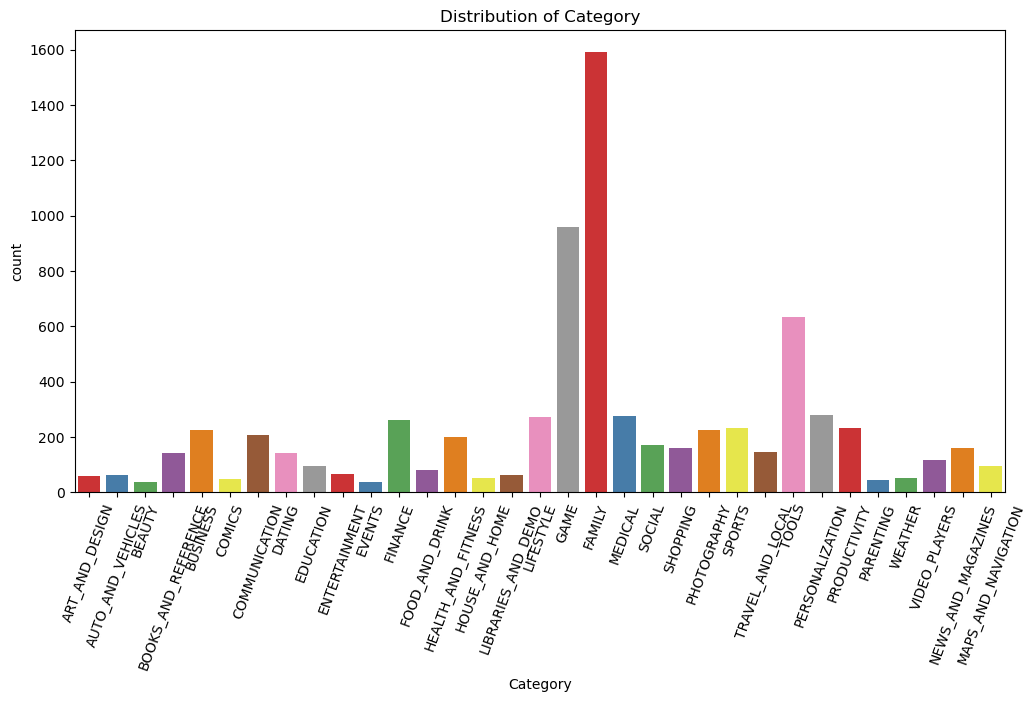

In [23]:
plt.rcParams['figure.figsize']=(12,6)
sns.countplot(x='Category',data=data,palette="Set1")
plt.xticks(rotation=70)
plt.title("Distribution of Category")
plt.show()

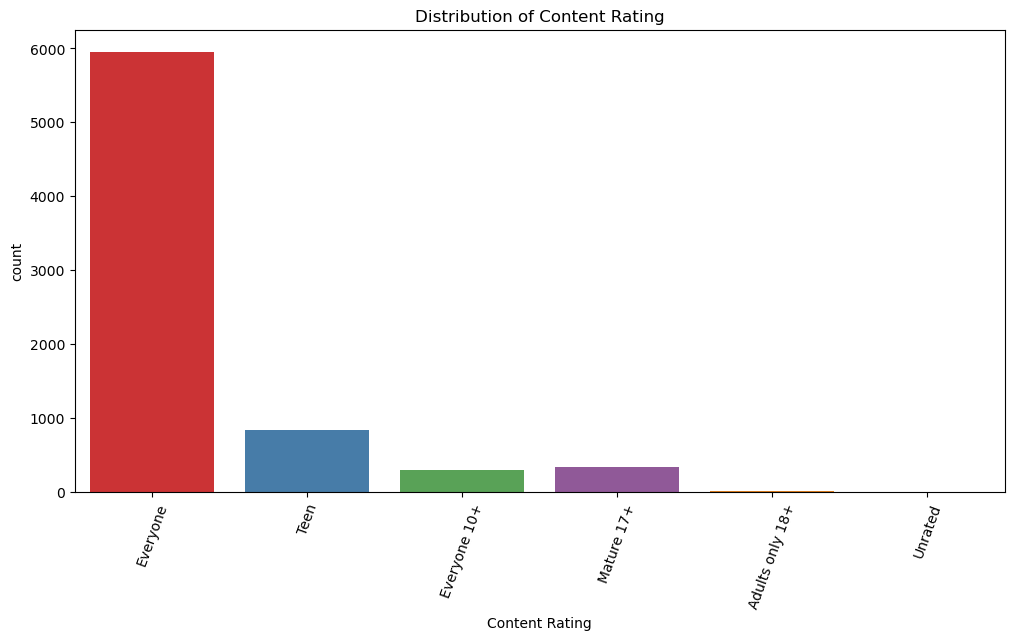

In [24]:
plt.rcParams['figure.figsize']=(12,6)
sns.countplot(x='Content Rating',data=data,palette="Set1")
plt.title("Distribution of Content Rating")
plt.xticks(rotation=70)
plt.show()

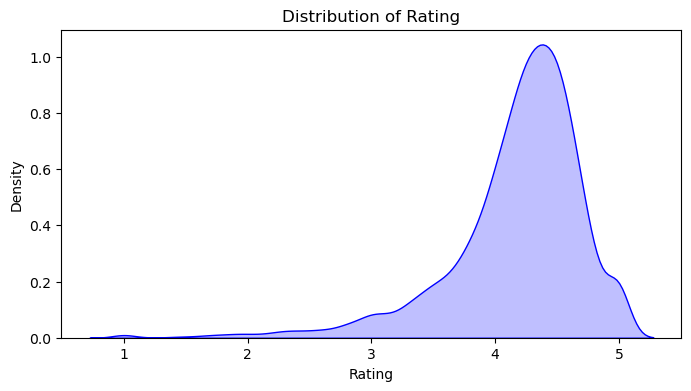

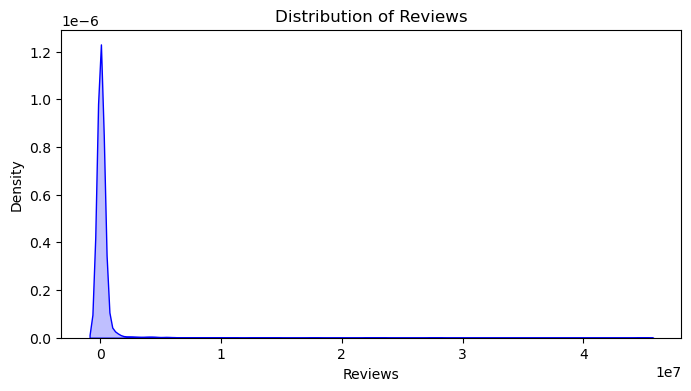

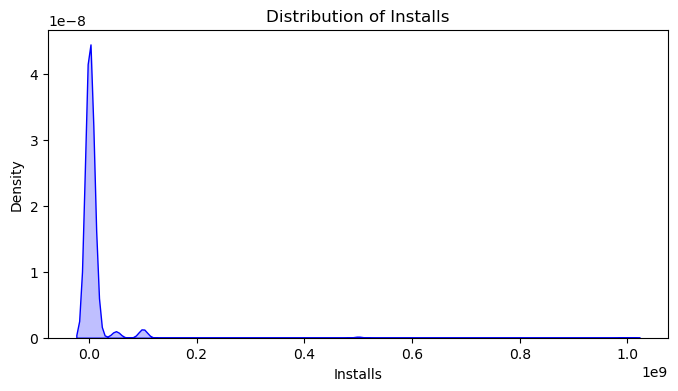

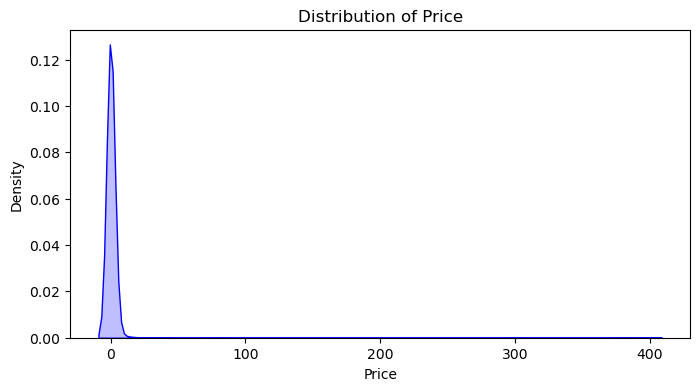

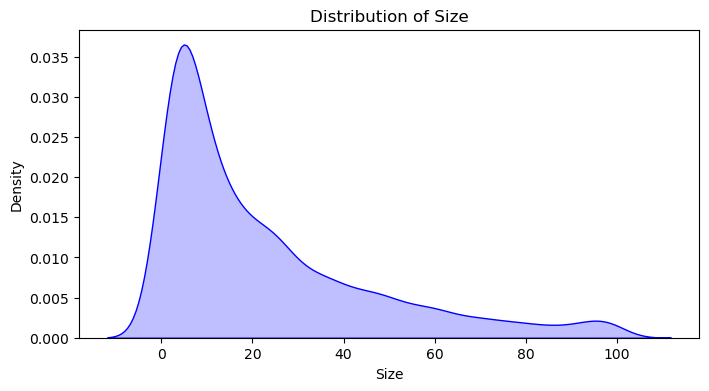

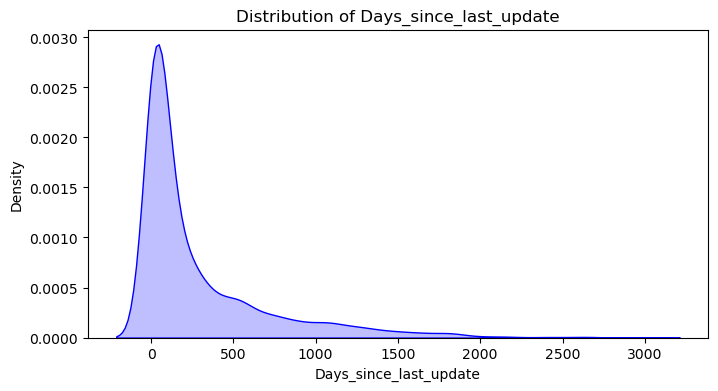

In [25]:
numeric_cols = ['Rating', 'Reviews', 'Installs', 'Price', 'Size', 'Days_since_last_update']
for i in range(6):
  plt.figure(figsize=(8,4))
  sns.kdeplot(data[numeric_cols[i]],color='blue',fill=True)
  plt.title("Distribution of "+numeric_cols[i])

<Axes: >

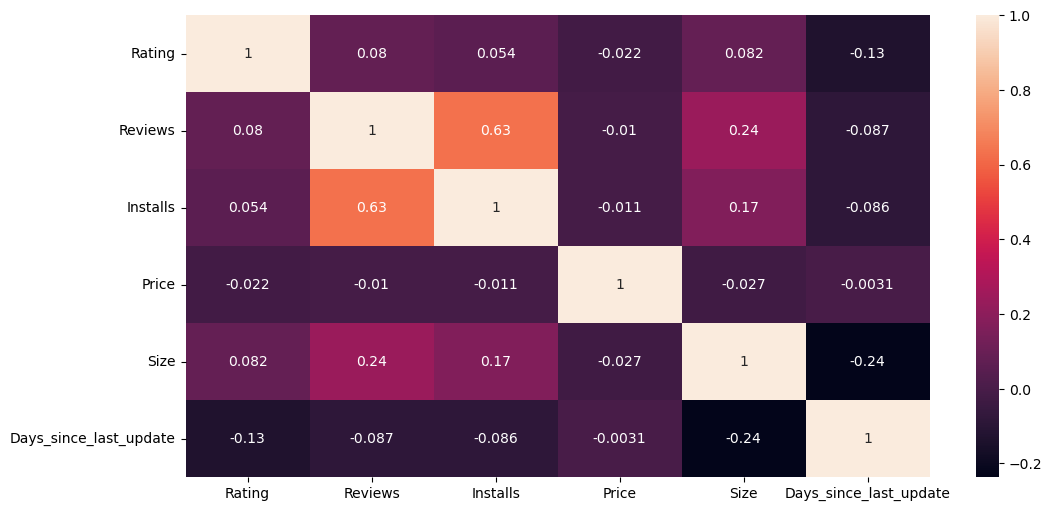

In [26]:
sns.heatmap(data[numeric_cols].corr(),annot=True)

## Data Encoding

<BarContainer object of 3 artists>

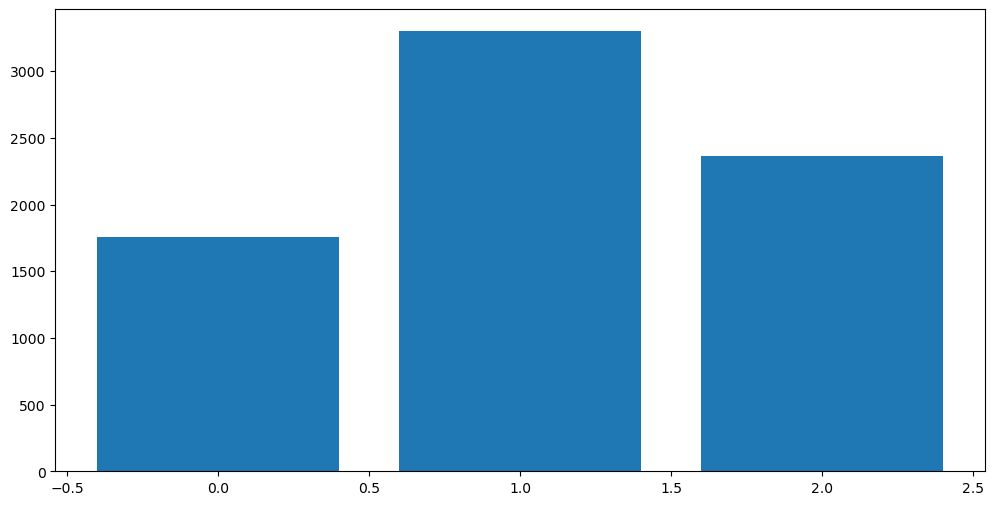

In [29]:
def categorize_rating(rating):
    if rating >= 1 and rating < 4:
        return 0
    elif rating >= 4 and rating < 4.5:
        return 1
    elif rating >= 4.5 and rating <= 5:
        return 2
    else:
       return np.nan  # Return NaN for ratings that don't match any condition
# Apply the function to the 'Rating' column to create the 'Rating Interval' column
data['Rating Interval'] = data['Rating'].apply(categorize_rating)
plt.bar(data['Rating Interval'].value_counts().index,data['Rating Interval'].value_counts())


In [30]:
data = pd.get_dummies(data, columns=['Category', 'Content Rating','Genres','Type'], dtype=float)
encoded_data_head = data.head()
original_shape = data.shape
encoded_shape = data.shape

## Standardization

In [32]:
def Standardization(dataframe):
    df_std = dataframe.copy()
    for col in df_std.columns:
        df_std[col] =(df_std[col]-df_std[col].mean())/df_std[col].std()
    return df_std

def normalizing(dataframe):
    df_norm = dataframe.copy()
    for col in df_norm.columns:
        df_norm[col] = (df_norm[col] - df_norm[col].min())/(df_norm[col].max() - df_norm[col].min())
    return df_norm

## Outlier Detection

### DB-SCAN

In [41]:
features = data[['Rating','Reviews', 'Price', 'Size', 'Installs','Days_since_last_update']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
dbscan = DBSCAN(eps=1, min_samples=5)
clusters_db = dbscan.fit_predict(features_scaled)
non_outlier_indices = (clusters_db != -1)
data_db = data[non_outlier_indices]
outliers_removed = len(data) - len(data_db)
data_db_preview = data_db[['Rating','Price', 'Reviews', 'Size', 'Installs','Days_since_last_update']].head()
print(outliers_removed)
print(data_db_preview)

45
   Rating  Price  Reviews  Size  Installs  Days_since_last_update
0     4.1    0.0      159  19.0     10000                     213
1     3.9    0.0      967  14.0    500000                     205
2     4.7    0.0    87510   8.7   5000000                       7
3     4.5    0.0   215644  25.0  50000000                      61
4     4.3    0.0      967   2.8    100000                      49


### IsolationForest

In [37]:
features = data[['Rating','Reviews', 'Price', 'Size', 'Installs','Days_since_last_update']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
clf = IsolationForest(random_state=0)
clusters_if = clf.fit_predict(features_scaled)
non_outlier_indices_if = (clusters_if != -1)
data_if = data[non_outlier_indices_if]
outliers_removed = len(data) - len(data_if)
data_if_preview = data_if[['Rating','Price', 'Reviews', 'Size', 'Installs','Days_since_last_update']]
outliers_removed, data_if_preview


(581,
        Rating  Price  Reviews    Size  Installs  Days_since_last_update
 0         4.1    0.0      159  19.000     10000                     213
 1         3.9    0.0      967  14.000    500000                     205
 2         4.7    0.0    87510   8.700   5000000                       7
 3         4.5    0.0   215644  25.000  50000000                      61
 4         4.3    0.0      967   2.800    100000                      49
 ...       ...    ...      ...     ...       ...                     ...
 10833     4.8    0.0       44   0.619      1000                    1599
 10834     4.0    0.0        7   2.600       500                     416
 10836     4.5    0.0       38  53.000      5000                     379
 10837     5.0    0.0        4   3.600       100                      33
 10840     4.5    0.0   398307  19.000  10000000                      14
 
 [6841 rows x 6 columns])